# Analysis file for fractional data from cluster simulations

## Update:
Changed the logistic regression funciton to a function with only slope and inflection point (k, p0) without scaling (no parameter L anymore)

## Preparation:
* Import packages
* Declare environment variables

In [1]:
# ------------------------- [Imports] -------------------------
# import argparse
import csv
import datetime as dt
import math
import numpy as np
import os
# import pandas as pd
import pickle as pickle
import random
import time
# import shutil

from matplotlib.lines import Line2D
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import matplotlib

from scipy.optimize import curve_fit
from scipy.stats import norm, pareto

In [2]:
# Declare working directory
current_dir = os.getcwd()
# print(f"Working from directory: {current_dir}")

# Declare model names
models = ["Q_Learning","Sarsa","MC","PTD"]

# Placeholder for the valid directories and their respective files
valid_directories_with_files = {}
valid_dirs = list()

# Isolate valid directoreis and their required data:
# Iterate over each directory in the list
for dir_name in os.listdir():
    # Check if the directory name is an integer
    if dir_name.isdigit():
        valid_dirs.append(dir_name)
valid_dirs = [int(x) for x in valid_dirs]
valid_dirs.sort()
valid_dirs = [str(x) for x in valid_dirs]

for dir_name in valid_dirs:
    # List all files in the directory
    try:
        files = os.listdir(dir_name)
        # Filter out the files which have "DataDump" with ".p" extension or "parameters" with ".csv" extension
        valid_files = [file for file in files if ("DataDump" in file and file.endswith(".p")) or 
                                                    ("parameters" in file and file.endswith(".csv"))]
        # If valid files are found, add them to the dictionary with their full paths
        if valid_files:
            valid_directories_with_files[dir_name] = [os.path.join(dir_name, file) for file in sorted(valid_files)]
    except FileNotFoundError:
        # If the directory does not exist, we skip it
        pass

# Show contents for valid directories and files
print(valid_directories_with_files)

# Output logfile
out_file = f"logfile.log"


{'1': ['1/DataDump_1.p', '1/parameters_1.csv'], '2': ['2/DataDump_2.p', '2/parameters_2.csv'], '3': ['3/DataDump_3.p', '3/parameters_3.csv'], '4': ['4/DataDump_4.p', '4/parameters_4.csv'], '5': ['5/DataDump_5.p', '5/parameters_5.csv']}


## Unpacking the data files:
* Load files from cluster as raw input
* Read dump file for Model results (Per round)
* Read parameter files for hyperparameter information (and Number of repetitions for agents)
* Store data in a structured dictionairy

In [3]:
def collect_datadump(my_dict, source):
    with (open(source,"rb")) as data_file:
        file_data = pickle.load(data_file)
    
    if bool(my_dict):
        for key, value in file_data.items():
            # print(f"updating key: {key}")
            my_dict[key].update(file_data[key])
    else:
        my_dict.update(file_data)

    return my_dict

model_results = {}
print(bool(model_results))
# for key,value in valid_directories_with_files.items():
#     print(f"directory: {key}, Data file access: {value[0]}, Parameterfile: {value[1]}")
#     collect_datadump(model_results, value[0])

"""###### Loading datadump for Multiple-parameter runs - analysis on result from full stacked runs"""
input_dir = "3"

value = valid_directories_with_files[input_dir]
print(f"directory: {input_dir}, Data file access: {value[0]}, Parameterfile: {value[1]}")
# collect_datadump(model_results, value[0])
with (open(value[0],"rb")) as data_file:
    model_results = pickle.load(data_file)

False
directory: 3, Data file access: 3/DataDump_3.p, Parameterfile: 3/parameters_3.csv


In [4]:
# for key, values in model_results.items():
#    print(f"Index: {key}, values: {values.keys()}")
# Load p-values from data    
p_values = list(model_results["SingleRound"].keys())

# Load decisions from data
# my_decisions = list(valid_directories)

"""Load decisions from downloaded data"""
my_decisions = model_results[models[0]].keys()
# my_decisions.append(1)
# my_decisions.sort()

### Unpacking the hyperparameters
* Same throughout experiment
* take sample hyperparameterfile for further Analysis
* Setup gatekeeper crosschecking the hyperparameters for all data-directories

In [5]:
hyperparameters ={}
model_parameters = {}

if 0:
    def collect_parameters(my_dict, Id, source):
        my_dict[key] = {}
        
        file=open(source, "r")
        reader = csv.reader(file)
        
        for line in reader:
            t=line[0],line[1]
            # print(t)
            my_dict[Id][line[0]] = line[1]
        
        return my_dict

    for key,value in valid_directories_with_files.items():
        print(f"directory: {key}, Data file access: {value[0]}, Parameterfile: {value[1]}")
        collect_parameters(model_parameters, key, value[1])


"""Load hyperparameters from parameterfile"""
file=open(value[1], "r")
reader = csv.reader(file)
for line in reader:
    t=line[0],line[1]
    hyperparameters[line[0]] = line[1]


hyperparameters

{'Parameter': 'Value',
 'reward1': '2.0',
 'reward2': '0.5',
 'reward3': '1.2',
 'episodes': '2500',
 'runs': '50',
 'discount': '0.5',
 'epsilon_method': 'decaying',
 'epsilon_initial_value': '0.3',
 'epsilon_decay_rate': '0.998',
 'epsilon_min_value': '0.02',
 'alpha_method': 'decaying',
 'alpha_initial_value': '0.9',
 'alpha_decay_rate': '0.995',
 'alpha_min_value': '0.01'}

In [6]:
# Hyperparameter setting:
episodes = int(hyperparameters["episodes"])
reward1  = float(hyperparameters["reward1"])
reward2  = float(hyperparameters["reward2"])
reward3  = float(hyperparameters["reward3"])
num_runs = int(hyperparameters["runs"])
gamma    = float(hyperparameters["discount"])

alpha_max      = float(hyperparameters["alpha_initial_value"])
epsilon_max    = float(hyperparameters["epsilon_initial_value"])
alpha_min      = float(hyperparameters["alpha_min_value"])
epsilon_min    = float(hyperparameters["epsilon_min_value"])
epsilon_method = hyperparameters["epsilon_method"]
alpha_method   = hyperparameters["alpha_method"]
alpha_rate     = float(hyperparameters["alpha_decay_rate"])
epsilon_rate   = float(hyperparameters["epsilon_decay_rate"])

In [7]:
if "II" in list(model_results.keys()):
   model_results["PTD"] = model_results["II"]
   del model_results["II"]

print(model_results.keys())


dict_keys(['SingleRound', 'Q_Learning', 'Sarsa', 'MC', 'PTD'])


In [8]:
"""Allow matplotlib to use latex formats"""
print(plt.rcParams["text.usetex"])

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "Helvetica"
})

False


## Results Visualization

### Function Definitions

In [9]:
def print_to_log(linein):
    with open(out_file, "a") as handle:
        handle.write(linein + "\n")

print_to_log("Results stored in: " + current_dir)
print_to_log("Run started at: " + dt.datetime.now().strftime("%m:%d:%Y %H:%M:%S"))

start_general_clock = dt.datetime.now()
data_file = "DataDump.p"

def write_parameters_to_csv(filename, params):
    """
    Write parameters to a CSV file.

    Parameters:
    - filename (str): The name of the CSV file.
    - params (dict): A dictionary containing the parameters to be written.
    """
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Parameter", "Value"])  # Writing headers

        for key, value in params.items():
            writer.writerow([key, value])

def compute_critical_p(p_values, mean_probabilities_bet2):
    """Compute the critical p value where agent is most indifferent between, closest to,  the two bets."""
    differences = np.abs(np.array(mean_probabilities_bet2) - 0.5)
    critical_index = np.argmin(differences)
    return p_values[critical_index]

def softmax(Q):
    """ Subtract the max value from each element in the array for numerical stability"""
    shift_Q = Q - np.max(Q)
    """Compute softmax values for Q-values."""
    expQ = np.exp(shift_Q)
    return expQ / expQ.sum()

# def logistic(p, L, k, p0):
#     return L / (1 + np.exp(-k*(p-p0)))

def logistic(p, k, p0):
    return 1 / (1 + np.exp(-k*(p-p0)))

def calculate_p_values_and_k(all_Q_values, p_values, episode_length):
    """Calculate the expected critical p-value and slope for a specific training length.
    Extract the Q-values for each p value at the given episode length and compute the softmax probabilities"""
    mean_probabilities_bet2 = []   # Store mean probabilities for choosing Bet 2 for each 'p'
    std_probabilities_bet2 = []    # Store standard deviations of probabilities for each 'p'

    for p in p_values:
        probs_bet2_for_p = []     # Store probabilities for choosing Bet 2 for current 'p' across all runs

        for run in all_Q_values[p]:
            Q_values_at_episode = all_Q_values[p][run][episode_length]  # Q-values at the specified episode length for each run
            ## ATTENTION: softmax function enhanced with shift for numerical stability
            prob_bet2 = softmax(Q_values_at_episode)[1]                 # Probability of choosing bet 2 using softmax on Q-values
            # prob_bet2 = np.argmax(Q_values_at_episode)
            probs_bet2_for_p.append(prob_bet2)

        # Compute mean and standard deviation for probabilities for each p
        mean_probabilities_bet2.append(np.mean(probs_bet2_for_p))
        std_probabilities_bet2.append(np.std(probs_bet2_for_p))

    # Curve fitting
    # We fit the mean probabilities to the logistic function
    try:
        # params, covariance = curve_fit(logistic, p_values, mean_probabilities_bet2, p0=[1, 1, 0.5])
        params, covariance = curve_fit(logistic, p_values, mean_probabilities_bet2, p0=[1, 0.5])
        # L, k, p0 = params
        k, p0 = params
        # p0_variance = covariance[2,2]
        p0_variance = covariance[1,1]
        std_p0=np.sqrt(p0_variance)
        success = 1
    except:
        # L, k, p0 = [1,1,0]
        k, p0 = [1,0]
        std_p0 = 0
        success = 0

    # return success, L, k, p0, std_p0, mean_probabilities_bet2, std_probabilities_bet2
    return success, 1, k, p0, std_p0, mean_probabilities_bet2, std_probabilities_bet2

def bet_1(W, p, r1, r2, N):
    """Simulate Bet 1 for N rounds."""
    wealth = W
    for _ in range(N):
        if random.random() < p:
            wealth *= r1
        else:
            wealth *= r2
    return wealth

def bet_2(W, r3, N):
    """Calculate wealth for Bet 2 after N rounds."""
    return W * (r3 ** N)

def decay_rate(a, b):
    return 1-a/b


### Model parameter Initialization

In [10]:
if 0:
    # Define parameters
    W = 10             # starting wealth
    actions = [1, 2]

    ## Model selection: ##
    starttime = dt.datetime.now()
    print_to_log(f"Project initialisation started at {dt.datetime.now()}")


### Training Single-Round Model

In [11]:
if 0:
    #------------------------- [Model Trainings] ------------------------------
    # Run single-round training for comparison (outside the num_decisions loop)
    all_Q_values_single_round = {}
    print_to_log(f"Training the single-round model started at {dt.datetime.now()}")
    model_results["SingleRound"] = {} # Change for low-data models

    for p in p_values:
        all_Q_values_single_round[p] = {}
        model_results["SingleRound"][p] = {} # Change for low-data models 
        for run in range(num_runs):
            epsilon_strategy = EpsilonStrategy(method=epsilon_method, initial_epsilon=epsilon_max, decay_rate = epsilon_rate, min_epsilon=epsilon_min)
            alpha_strategy = DecayStrategy(method=alpha_method, initial_value=alpha_max, decay_rate=alpha_rate, min_value=alpha_min)


            Q_values_over_time_single_round = train_agent(p)  # Single-round training

            all_Q_values_single_round[p][run] = Q_values_over_time_single_round
            model_results["SingleRound"][p][run] = Q_values_over_time_single_round[-10:]

    print_to_log(f"Finished training single-round model at {dt.datetime.now()}")

### Training Models on Multiple Rounds

In [12]:
if 0:
    # ------------------------- [Multiple-Round Model Trainings] -------------------------
    print_to_log(f"Models training started at {dt.datetime.now()}")
    for model_name in models:
        all_Q_values_multiple_rounds = {}
        model_results[model_name] = {} # Change for low-data models
        for rounds in my_decisions:
            print_to_log(f"Training for {rounds} decision(s)")
            all_Q_values_multiple_rounds[rounds] = {}
            model_results[model_name][rounds] = {} # Change for low-data models
            for p in p_values:
                all_Q_values_multiple_rounds[rounds][p] = {}
                model_results[model_name][rounds][p] = {} # Change for low-data models
                for run in range(num_runs):
                    epsilon_strategy = EpsilonStrategy(method=epsilon_method, initial_epsilon=epsilon_max, decay_rate = epsilon_rate, min_epsilon=epsilon_min)
                    alpha_strategy = DecayStrategy(method=alpha_method, initial_value=alpha_max, decay_rate=alpha_rate, min_value=alpha_min)


                    if model_name == "Q_Learning":
                        raw_Q_values = train_QLearning(p, rounds)
                    elif model_name == "Sarsa":
                        raw_Q_values = train_Sarsa(p, rounds)
                    elif model_name == "MC":
                        raw_Q_values = train_MonteCarlo(p, rounds, mc_update_frequency)
                    elif model_name == "PTD":
                        raw_Q_values = monte_carlo_q_learning_with_TD(p, rounds)
                    else:
                        print_to_log(f"Model {model_name} not reckognized")

                    all_Q_values_multiple_rounds[rounds][p][run] = raw_Q_values
                    model_results[model_name][rounds][p][run] = raw_Q_values[-10:] # Change for low-data models
        print_to_log(f"Training {model_name} completed at {dt.datetime.now()}!")

    print_to_log(f"Finished training multiple-round models at {dt.datetime.now()}")

## Visualization - Data Analysis

### Visualization Single Round Model

<>:37: SyntaxWarning: invalid escape sequence '\h'
<>:37: SyntaxWarning: invalid escape sequence '\h'
/var/folders/0h/d2qwr7yd2q9f88ydzf3b9m940000gn/T/ipykernel_3279/420400650.py:37: SyntaxWarning: invalid escape sequence '\h'
  plt.axvline(p0_value, color='green', linestyle='--', label='$\hat{p}_{0}$: '+f'{p0_value:.2f}') #, k: {-(k_value/4):.2f}')


<Figure size 1000x600 with 0 Axes>

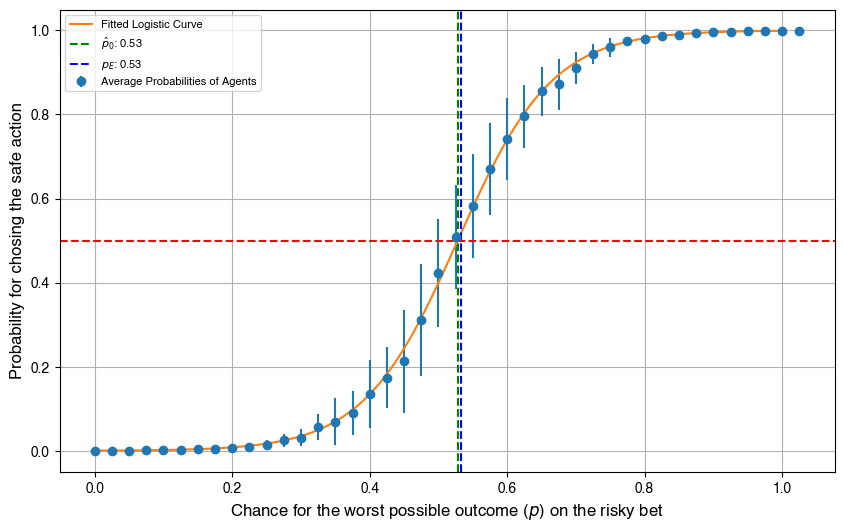

In [13]:
# ------------------------- [Visualization] -------------------------
# Single round Output
plt.figure(figsize=(10,6))
markers = ['o', 's', '^', 'v', '>', '<', 'p', '*', '+', 'x']
colors = plt.cm.viridis(np.linspace(0, 1, len(list(model_results.keys())) +1))
ls = 12 # font size axis labels
fs = 12 # font size legends
ts = 12 # font size ticks

# Calculate the critical p-value and k using the function for the final episode
success, L_value, k_value, p0_value, p0_std, mean_probabilities, std_probabilities = calculate_p_values_and_k(model_results["SingleRound"], p_values, -1)

# Calculate the critical p value using a helper function
practical_p_critical = compute_critical_p(p_values, mean_probabilities)

# Theoretical critical p-value based on reward structure
theoretical_p_critical = (reward3 - reward1) / (reward2 - reward1)
theoretical_k = -(reward1 - reward2)
time_average_growth = (math.log(reward3) - math.log(reward1))/(math.log(reward2) - math.log(reward1))

# Predicted values from the logistic function using the returned k-value
fine_p_values = np.linspace(0,1,1000)
if success:
    # predicted_probs = logistic(fine_p_values, L_value, k_value, p0_value)
    predicted_probs = logistic(fine_p_values, k_value, p0_value)
# predicted_probs = logistic(np.array(p_values), L_value, k_value, p0_value)

# Plot
plt.figure(figsize=(10,6))
plt.errorbar(p_values, mean_probabilities, yerr=std_probabilities, fmt='o', label="Average Probabilities of Agents")
if success:
    plt.plot(fine_p_values, predicted_probs, '-', label="Fitted Logistic Curve")
else:
    plt.plot(0,0,"-",label="No logisitic fit possible")
    
plt.axhline(0.5, color='red', linestyle='--')
plt.axvline(p0_value, color='green', linestyle='--', label='$\hat{p}_{0}$: '+f'{p0_value:.2f}') #, k: {-(k_value/4):.2f}')
plt.axvline(theoretical_p_critical, color='blue', linestyle='--', label='$p_{E}$: '+f'{theoretical_p_critical:.2f}') #, k: {theoretical_k:.2f}')
# plt.axvline(practical_p_critical, color='black', linestyle='--', label=f'Calculated Critical p: {practical_p_critical:.2f}')
plt.xlabel('Chance for the worst possible outcome ($p$) on the risky bet',fontsize=ls)
plt.ylabel('Probability for chosing the safe action',fontsize=ls)
# plt.title('Average Probability of Choosing Bet 2 as a function of p')
plt.legend(fontsize=8)
plt.grid(True)

# plt.savefig(f"ID{my_Id}_SingleRoundModel_Policy.png",dpi = 100, bbox_inches="tight")
plt.savefig(f"SingleRoundModel_Policy.pdf",dpi = 600, bbox_inches="tight")

### Visualization All Models - one round

In [14]:
colors = plt.cm.viridis(np.linspace(0, 1, len(list(model_results.keys())) +1))
print(colors)

[[0.267004 0.004874 0.329415 1.      ]
 [0.253935 0.265254 0.529983 1.      ]
 [0.163625 0.471133 0.558148 1.      ]
 [0.134692 0.658636 0.517649 1.      ]
 [0.477504 0.821444 0.318195 1.      ]
 [0.993248 0.906157 0.143936 1.      ]]


# Remove in a minute

In [15]:
model_results["Q_Learning"][1].keys()

dict_keys([0.0, 0.025, 0.05, 0.07500000000000001, 0.1, 0.125, 0.15000000000000002, 0.17500000000000002, 0.2, 0.225, 0.25, 0.275, 0.30000000000000004, 0.325, 0.35000000000000003, 0.375, 0.4, 0.42500000000000004, 0.45, 0.47500000000000003, 0.5, 0.525, 0.55, 0.5750000000000001, 0.6000000000000001, 0.625, 0.65, 0.675, 0.7000000000000001, 0.7250000000000001, 0.75, 0.775, 0.8, 0.8250000000000001, 0.8500000000000001, 0.875, 0.9, 0.925, 0.9500000000000001, 0.9750000000000001, 1.0, 1.0250000000000001])

## remove no more

<>:46: SyntaxWarning: invalid escape sequence '\h'
<>:46: SyntaxWarning: invalid escape sequence '\h'
/var/folders/0h/d2qwr7yd2q9f88ydzf3b9m940000gn/T/ipykernel_3279/118159111.py:46: SyntaxWarning: invalid escape sequence '\h'
  label=f"{model_name}: "+"$\hat{p}_{0}$"+f"={p0_value:.2f}")


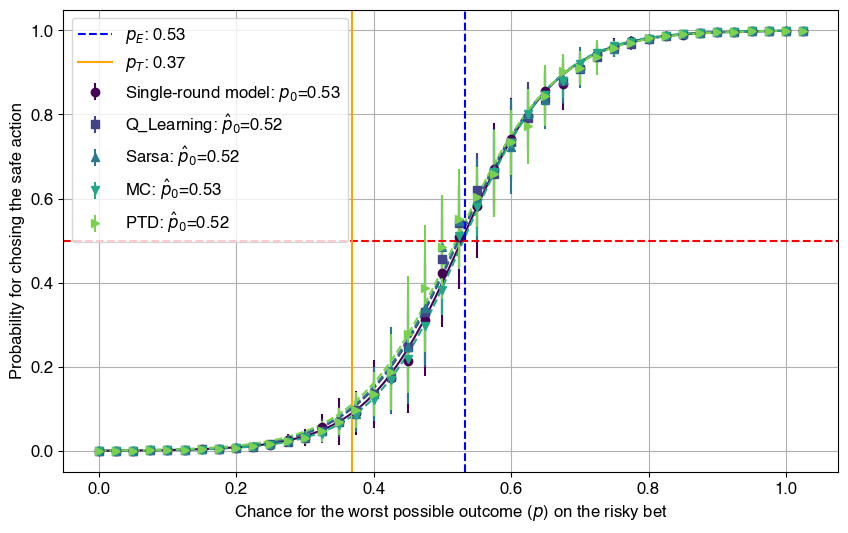

In [17]:
# ------------------------- [Visualization] -------------------------
# Multiple rounds Output
plt.figure(figsize=(10,6))
markers = ['o', 's', '^', 'v', '>', '<', 'p', '*', '+', 'x']
colors = plt.cm.viridis(np.linspace(0, 1, len(list(model_results.keys())) +1))
ls = 12 # font size axis labels
fs = 12 # font size legends
ts = 12 # font size ticks
x_ticks = list(i/10 for i in range(0,11,2))
x_ticklabels = list(f"{i/10:.1f}" for i in range(0,11,2))
y_ticks = x_ticks
y_ticklabels = x_ticklabels

time_average_growth = (math.log(reward3) - math.log(reward1))/(math.log(reward2) - math.log(reward1))

# Add single-run model as well:
success, L_value, k_value, p0_value, p0_std, mean_probabilities, std_probabilities = calculate_p_values_and_k(model_results["SingleRound"], p_values, -1)
if success:
    # predicted_probs = logistic(fine_p_values, L_value, k_value, p0_value)
    predicted_probs = logistic(fine_p_values, k_value, p0_value)
    plt.errorbar(p_values, mean_probabilities, yerr=std_probabilities,
                    color=colors[0],
                    fmt=markers[0],
                    label="Single-round model: $p_{0}$"+f"={p0_value:.2f}")
    plt.plot(fine_p_values, predicted_probs, '-',
                color=colors[0],
                )
else:
    print_to_log(f"Fitting problem for single-round model")
    plt.errorbar(p_values, mean_probabilities, yerr=std_probabilities,
                    color=colors[0],
                    fmt=markers[0],
                    label=f"Single-round model: Fit Failed!")
    
    
# Calculate the critical p-value and k using the function for the final episode
vision_index = 1
for model_name in models:
    success, L_value, k_value, p0_value, p0_std, mean_probabilities, std_probabilities = calculate_p_values_and_k(model_results[model_name][1], p_values, -1)
    if success:
        # predicted_probs = logistic(fine_p_values, L_value, k_value, p0_value)
        predicted_probs = logistic(fine_p_values, k_value, p0_value)
        plt.errorbar(p_values, mean_probabilities, yerr=std_probabilities,
                     color=colors[vision_index],
                     fmt=markers[vision_index],
                     label=f"{model_name}: "+"$\hat{p}_{0}$"+f"={p0_value:.2f}")
        plt.plot(fine_p_values, predicted_probs, '--',
                 color=colors[vision_index],
                 )
        vision_index += 1 if vision_index < len(colors)-1 else 0
    else:
        print_to_log(f"Fitting problem for model {model_name} for one-round iteration")
        plt.errorbar(p_values, mean_probabilities, yerr=std_probabilities,
                     color=colors[vision_index],
                     fmt=markers[vision_index],
                     label=f"{model_name}: Fit Failed!")
        

# Plot
plt.axhline(0.5, color='red', linestyle='--')
plt.axvline(theoretical_p_critical, color='blue', linestyle='--', label='$p_{E}$: '+f'{theoretical_p_critical:.2f}') # , k: {-theoretical_k:.2f}')
plt.axvline(time_average_growth, color='orange', linestyle='-', label='$p_{T}$: '+f'{time_average_growth:.2f}')
plt.xlabel('Chance for the worst possible outcome ($p$) on the risky bet',fontsize=ls)
plt.ylabel('Probability for chosing the safe action',fontsize=ls)
#plt.ylabel('$\mathbb{P}$(safe)',fontsize=ls)
plt.xticks(fontsize=ts)
plt.yticks(fontsize=ts)
# plt.title(f'Model Probability for Bet 2 as a function of p')
plt.legend(fontsize=fs)
plt.grid(True)

plt.savefig(f"All_Models_FirstRound.pdf",dpi = 600, bbox_inches="tight",format="pdf")

### Visualization All Models - multiple rounds

<>:29: SyntaxWarning: invalid escape sequence '\h'
<>:55: SyntaxWarning: invalid escape sequence '\h'
<>:29: SyntaxWarning: invalid escape sequence '\h'
<>:55: SyntaxWarning: invalid escape sequence '\h'
/var/folders/0h/d2qwr7yd2q9f88ydzf3b9m940000gn/T/ipykernel_3240/1841307178.py:29: SyntaxWarning: invalid escape sequence '\h'
  label="Single-round model: $\hat{p}_{0}$"+f"={p0_value:.2f}")
/var/folders/0h/d2qwr7yd2q9f88ydzf3b9m940000gn/T/ipykernel_3240/1841307178.py:55: SyntaxWarning: invalid escape sequence '\h'
  label=f"{round} rounds: "+"$\hat{p}_{0}$"+f"={p0_value:.2f}")


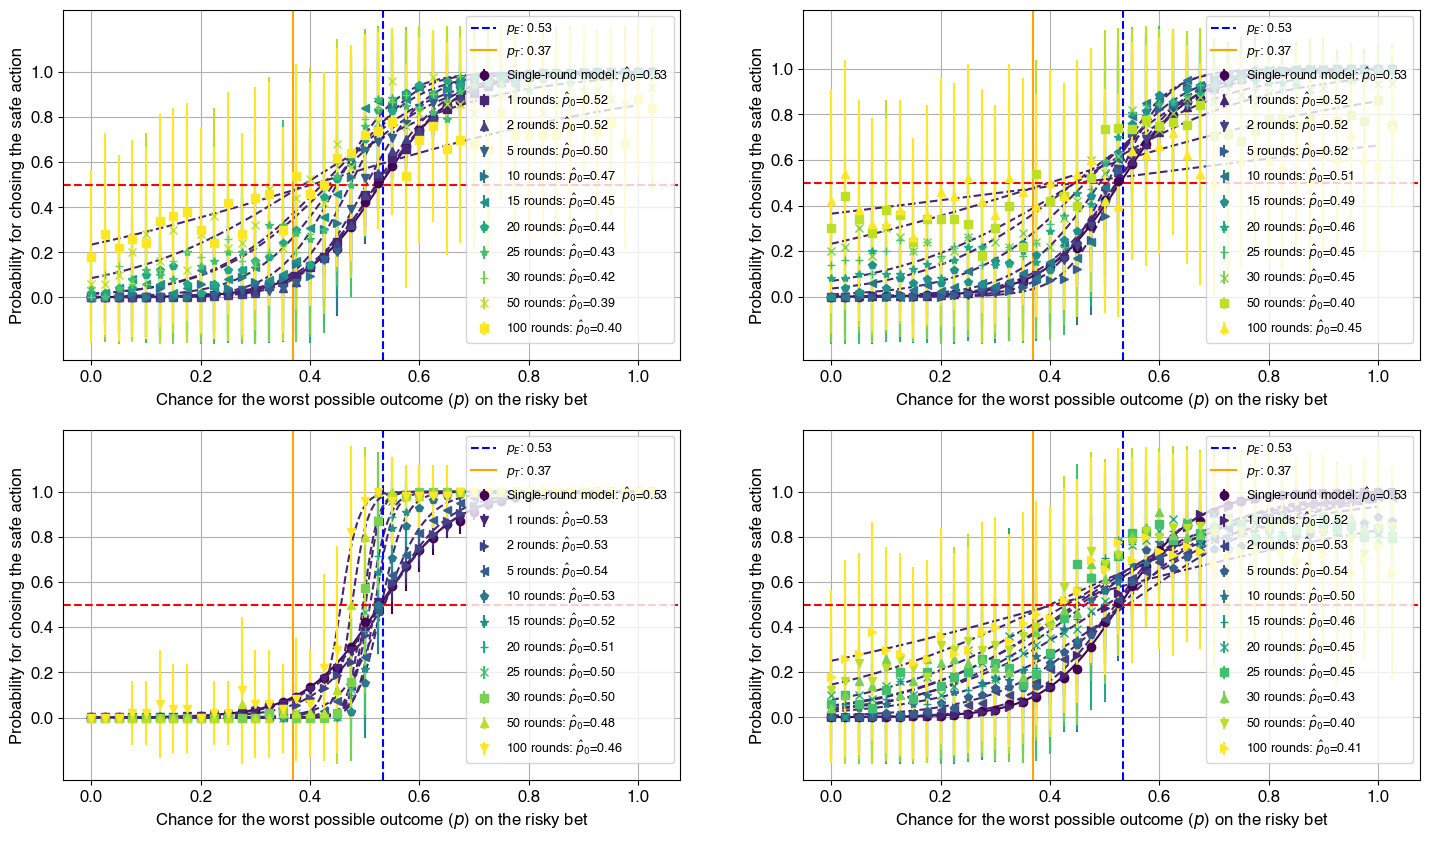

In [ ]:
# ------------------------- [Visualization] -------------------------
# Multiple Models visualization
x = 0
y = 0
x_len = int(len(models)/2)
y_len = len(models)-int(len(models)/2)
_, axs = plt.subplots(x_len,y_len,figsize=(17.5,10))
colors = plt.cm.viridis(np.linspace(0, 1, len(my_decisions) +1))

## New addition 05/02/2024:
model_policies = {}
## end new lines 05/02/2024
marker_index = 1
color_index = 1

for model_name in models:
    print_to_log(f"Generating output for model {model_name}")
    ## New addition 05/02/2024:
    model_policies[model_name] = {}
    ## end new lines 05/02/2024
    # Add single-run model as well:
    success, L_value, k_value, p0_value, p0_std, mean_probabilities, std_probabilities = calculate_p_values_and_k(model_results["SingleRound"], p_values, -1)
    if success:
        # predicted_probs = logistic(fine_p_values, L_value, k_value, p0_value)
        predicted_probs = logistic(fine_p_values, k_value, p0_value)
        axs[x][y].errorbar(p_values, mean_probabilities, yerr=std_probabilities,
                        color=colors[0],
                        fmt=markers[0],
                        label="Single-round model: $\hat{p}_{0}$"+f"={p0_value:.2f}")
        axs[x][y].plot(fine_p_values, predicted_probs, '-',
                    color=colors[0],
                    )

    else:
        print_to_log(f"Fit Failed for single-round model!")
        axs[x][y].errorbar(p_values, mean_probabilities, yerr=std_probabilities,
                        color=colors[0],
                        fmt=markers[0],
                        label=f"Single-round model: Fit Failed!")
        
    # Calculate the critical p-value and k using the function for the final episode
    vision_index = 1
    for round in my_decisions:
        success, L_value, k_value, p0_value, p0_std, mean_probabilities, std_probabilities = calculate_p_values_and_k(model_results[model_name][round], p_values, -1)
        if success:
            # predicted_probs = logistic(fine_p_values, L_value, k_value, p0_value)
            predicted_probs = logistic(fine_p_values, k_value, p0_value)
            axs[x][y].plot(fine_p_values, predicted_probs, '--',
                color=colors[vision_index],
                #label=f"Fitted Critical rounds {round:.2f}: p={p0_value:.2f}"
                )
            axs[x][y].errorbar(p_values, mean_probabilities, yerr=std_probabilities,
                    color=colors[color_index],
                    fmt=markers[marker_index],
                    label=f"{round} rounds: "+"$\hat{p}_{0}$"+f"={p0_value:.2f}")
            model_policies[model_name][round] = [p0_value, p0_std]
        else:
            print_to_log(f"Fit Failed for model {model_name} on {round} training rounds")
            axs[x][y].errorbar(p_values, mean_probabilities, yerr=std_probabilities,
                    color=colors[color_index],
                    fmt=markers[marker_index],
                    label=f"{round} rounds: Fit Failed!")

        if marker_index < len(markers)-1:
            marker_index += 1
        else:
            marker_index = 1
        if color_index < len(colors)-1:
            color_index += 1
        else:
            color_index = 1

    # Plot
    axs[x][y].axhline(0.5, color='red', linestyle='--')
    axs[x][y].axvline(theoretical_p_critical, color='blue', linestyle='--', label='$p_{E}$: '+f'{theoretical_p_critical:.2f}')
    axs[x][y].axvline(time_average_growth, color='orange', linestyle='-', label='$p_{T}$: '+f'{time_average_growth:.2f}')
    axs[x][y].set_xlabel('Chance for the worst possible outcome ($p$) on the risky bet', fontsize=ls)
    axs[x][y].set_ylabel('Probability for chosing the safe action', fontsize=ls)
    
    axs[x][y].set_xticks(x_ticks)
    axs[x][y].set_xticklabels(x_ticks,fontsize=ts)
    axs[x][y].set_yticks(y_ticks)
    axs[x][y].set_yticklabels(y_ticks,fontsize=ts)

    # axs[x][y].set_title(f'Model {model_name} results as a function of p')
    axs[x][y].legend(fontsize=9)
    axs[x][y].grid(True)

    # Plot number:
    if y < y_len-1:
        y += 1
    else:
        y = 0
    if x < x_len and y == 0:
        x += 1

# plt.savefig(f"ID{my_Id}_All_Models_AllRounds.png",dpi = 100, bbox_inches="tight",format="png")
plt.savefig(f"All_Models_AllRounds.pdf",dpi = 600, bbox_inches="tight",format="pdf")

print_to_log(f"Saved figure on multiple rounds All_Models_AllRounds.png")

### Visualization Policy Evolution

In [ ]:
if 0:
    print(model_policies.items())
    for model_name, results in model_policies.items():
        for round, p_estimates in results.items():
            print(f"Model: {model_name}: p = {p_estimates[0]}, var(p) = {p_estimates[1]}")
    success, L_value, k_value, p0_value, p0_std, mean_probabilities, std_probabilities = calculate_p_values_and_k(model_results[model_name][round], p_values, -1)
    print(success, L_value, k_value, p0_value, p0_std, mean_probabilities, std_probabilities)

<>:50: SyntaxWarning: invalid escape sequence '\h'
<>:50: SyntaxWarning: invalid escape sequence '\h'
/var/folders/0h/d2qwr7yd2q9f88ydzf3b9m940000gn/T/ipykernel_3240/291640023.py:50: SyntaxWarning: invalid escape sequence '\h'
  plt.ylabel("$\hat{p}_{0}$",fontsize=ls)


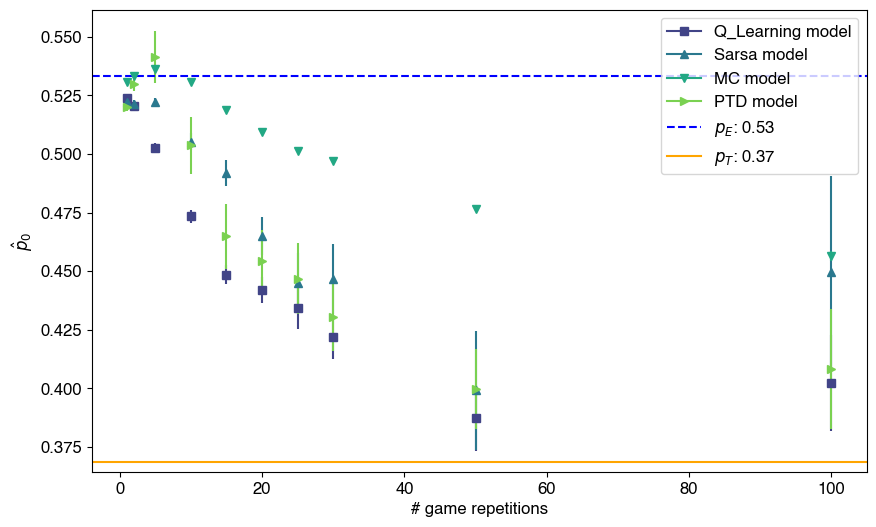

In [ ]:
## New addition 05/02/2024:
plt.figure(figsize=(10,6))

#markers = ['o', 's', '^', 'v', '>', '<', 'p', '*', '+', 'x']
#colors = plt.cm.viridis(np.linspace(0, 1, len(models)+1))
markers = ['o', 's', '^', 'v', '>', '<', 'p', '*', '+', 'x']
colors = plt.cm.viridis(np.linspace(0, 1, len(list(model_results.keys())) +1))

legend_string = list()
vision_index = 1

for model_name, results in model_policies.items():
    for round, p_estimates in results.items():
        # if p_estimates[1] > min(p_estimates[0], 1-p_estimates[0]):
        #     std_p0 = min(p_estimates[0], 1-p_estimates[0])
        # else:
        #     std_p0 = p_estimates[1]
        std_p0 = p_estimates[1]
        # axs[x][y]
        plt.errorbar(round, p_estimates[0], yerr=std_p0,
                color=colors[vision_index],
                marker=markers[vision_index],
                # label=f"Average Probabilities for {round} rounds: p={p0_value:.2f}"
                )

    legend_string.append(Line2D([0], [0],
                                color=colors[vision_index],
                                marker = markers[vision_index],
                                label=f"{model_name} model")
                                )
    vision_index = vision_index+1 if vision_index < min(len(markers),len(colors))-1 else 1
    

# Plot
# plt.axhline(0.5, color='red', linestyle='--')
plt.axhline(time_average_growth, color='orange', linestyle='-', label='$p_{T}$: '+f'{time_average_growth:.2f}')
plt.axhline(theoretical_p_critical, color='blue', linestyle='--', label='$p_{E}$: '+f'{theoretical_p_critical:.2f}') # , k: {-theoretical_k:.2f}')
legend_string.append(Line2D([0], [0],
                                color="blue",
                                linestyle='--',
                                label='$p_{E}$: '+f'{theoretical_p_critical:.2f}') #, k: {-theoretical_k:.2f}')
                                )
legend_string.append(Line2D([0], [0],
                                color="orange",
                                linestyle="-",
                                label='$p_{T}$: '+f'{time_average_growth:.2f}')
                                )
                                
plt.xlabel("# game repetitions",fontsize=ls)
plt.ylabel("$\hat{p}_{0}$",fontsize=ls)
plt.xticks(fontsize=ts)
plt.yticks(fontsize=ts)
# plt.title("Estimated policy change")
plt.legend(handles=legend_string, frameon=True, loc='best',fontsize=fs)

# plt.savefig(f"ID{my_Id}_PolicyEvolution.png",dpi = 100, bbox_inches="tight",format="png")
plt.savefig(f"PolicyEvolution.pdf",dpi = 600, bbox_inches="tight",format="pdf")
## end new lines 05/02/2024

##### NOTE ON Formatting:
## Set the ticks to be spread over decent values (0.40, 0.45, and add p_T and P_E)

### Visualization: No-Fit

In [ ]:
print(os.getcwd())
test_array = np.empty(shape=(2,5))
print(test_array)

/Users/bertverbruggen/Library/CloudStorage/OneDrive-VrijeUniversiteitBrussel/Documenten/Documents/Onderzoek/IntegratedIntelligence/RL_Experiment/Paper2023/paper/Data/Data_Analysis/GitHub_Publication
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


## Extra Result: Wealth progression through expected value or time-growth

In [ ]:
nb_agents = 500  # Number of virtual agents in Simulation
num_decisions = 500 # Number of steps
initial_wealth = 1

agent_results = {}
agent_actions = {}
legend_string = list()

reward1 = 2
reward2 = 0.5
reward3 = 1.2

theoretical_p_critical = (reward3 - reward1) / (reward2 - reward1)
time_average_growth = (math.log(reward3) - math.log(reward1))/(math.log(reward2) - math.log(reward1))

for optimizer in [0,1]: #(0: time average growth, 1: expected value)
    agent_results[optimizer] = np.zeros(shape=(nb_agents,num_decisions))
    agent_actions[optimizer] = np.zeros(shape=(nb_agents,num_decisions))

    for agent in range(nb_agents):
        # agent_results[optimizer][agent] = list()
        # agent_actions[optimizer][agent] = list()
        wealth = initial_wealth
        # recorded_actions = list()
        # recorded_wealth  = list()

        for decision in range(num_decisions):
            # p = np.random.uniform(0, 1)
            p = (np.random.randint(0, 10))/10
            # p = np.random.normal(time_average_growth+(theoretical_p_critical-time_average_growth)/2, theoretical_p_critical-time_average_growth)
            if optimizer: # Expected value optimizer
                action = 1 if p < theoretical_p_critical else 0
            else: # time growth optimizer
                action = 1 if p < time_average_growth else 0
            # recorded_actions.append(action)
            agent_actions[optimizer][agent][decision] = action

            if action:
                if np.random.uniform(0, 1) < p:
                    wealth *= reward2
                else:
                    wealth *= reward1
            else:  # Safe bet
                wealth *= reward3
            # recorded_wealth.append(wealth)
            agent_results[optimizer][agent][decision] = wealth
        # agent_results[optimizer][agent] = recorded_wealth
        # agent_actions[optimizer][agent] = recorded_actions
        # plt.plot(recorded_wealth,color=colors[optimizer])



<>:58: SyntaxWarning: invalid escape sequence '\l'
<>:58: SyntaxWarning: invalid escape sequence '\l'
/var/folders/0h/d2qwr7yd2q9f88ydzf3b9m940000gn/T/ipykernel_3240/2565543233.py:58: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel("$\log_{10}{}$(Cumulated Wealth)",fontsize=ls)


all done


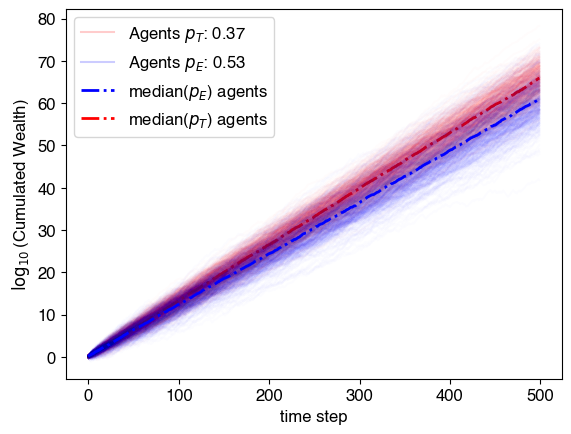

In [ ]:
legend_string = list()

median_growth = np.empty(shape=(2,num_decisions))
mean_growth = np.empty(shape=(2,num_decisions))

colors = ['red','blue',"white","green"]

for optimizer in [0,1]:
    median_growth[optimizer] = np.median(agent_results[optimizer],axis=0)
    mean_growth[optimizer] = np.mean(agent_results[optimizer],axis=0)
    for agent_path in agent_results[optimizer]:
        plt.plot(np.log10(agent_path),color=colors[optimizer],alpha=0.01)
    plt.plot(np.log10(median_growth[optimizer]),'-.',linewidth=2, color=colors[optimizer],alpha=1)
    # plt.plot(np.log10(mean_growth[optimizer]),':', linewidth=2, color=colors[optimizer],alpha=1)

legend_string.append(Line2D([0], [0],
                                color="red",
                                linestyle='-',
                                alpha=0.2,
                                label='Agents $p_{T}$: '+f'{time_average_growth:.2f}') 
                                )
legend_string.append(Line2D([0], [0],
                                color="blue",
                                linestyle='-',
                                alpha=0.2,
                                label='Agents $p_{E}$: '+f'{theoretical_p_critical:.2f}') 
                                )
"""Representation of mean growth rates, not useful for plot
legend_string.append(Line2D([0], [0],
                                color="blue",
                                linestyle='-',
                                linewidth=2,
                                label='Mean($p_{E}$) agents') 
                                )
legend_string.append(Line2D([0], [0],
                                color="red",
                                linestyle='-',
                                linewidth=2,
                                label='Mean($p_{T}$) agents')
                                )
"""

legend_string.append(Line2D([0], [0],
                                color="blue",
                                linestyle='-.',
                                linewidth=2,
                                label='median($p_{E}$) agents')
                                )
legend_string.append(Line2D([0], [0],
                                color="red",
                                linestyle='-.',
                                linewidth=2,
                                label='median($p_{T}$) agents')
                                )

print("all done")
plt.xlabel("time step",fontsize=ls)
plt.ylabel("$\log_{10}{}$(Cumulated Wealth)",fontsize=ls)
plt.xticks(fontsize=ts)
plt.yticks(fontsize=ts)
# plt.title("Estimated policy change")
plt.legend(handles=legend_string, frameon=True, loc='best',fontsize=fs)

plt.savefig(f"PolicySimulation.pdf",dpi = 200, bbox_inches="tight",format="pdf")

plt.show()

In [ ]:
test_array = np.arange(0,10)
test_array = test_array.reshape((2,5))
print(test_array)
print(f"Median across axis 0: {np.median(test_array,axis=0)}")
print(f"Mean across axis 0: {np.mean(test_array,axis=0)}")
print(f"Median across axis 1: {np.median(test_array,axis=1)}")
print(f"Mean across axis 1: {np.mean(test_array,axis=1)}")

[[0 1 2 3 4]
 [5 6 7 8 9]]
Median across axis 0: [2.5 3.5 4.5 5.5 6.5]
Mean across axis 0: [2.5 3.5 4.5 5.5 6.5]
Median across axis 1: [2. 7.]
Mean across axis 1: [2. 7.]


<>:96: SyntaxWarning: invalid escape sequence '\l'
<>:96: SyntaxWarning: invalid escape sequence '\l'
/var/folders/0h/d2qwr7yd2q9f88ydzf3b9m940000gn/T/ipykernel_3240/4276001462.py:96: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel("$\log_{10}{}$(Cumulated Wealth)",fontsize=ls)


all done


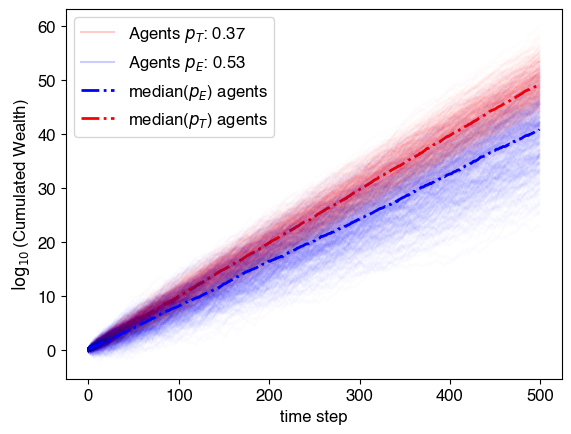

In [ ]:
# Simulation based on Gaussian distribution for parameter p

agent_results = {}
agent_actions = {}
legend_string = list()

reward1 = 2
reward2 = 0.5
reward3 = 1.2

theoretical_p_critical = (reward3 - reward1) / (reward2 - reward1)
time_average_growth = (math.log(reward3) - math.log(reward1))/(math.log(reward2) - math.log(reward1))

for optimizer in [0,1]: #(0: time average growth, 1: expected value)
    agent_results[optimizer] = np.zeros(shape=(nb_agents,num_decisions))
    agent_actions[optimizer] = np.zeros(shape=(nb_agents,num_decisions))

    for agent in range(nb_agents):
        wealth = initial_wealth
        
        for decision in range(num_decisions):
            p = np.random.normal(time_average_growth+(theoretical_p_critical-time_average_growth)/2, theoretical_p_critical-time_average_growth)
            if optimizer: # Expected value optimizer
                action = 1 if p < theoretical_p_critical else 0
            else: # time growth optimizer
                action = 1 if p < time_average_growth else 0
            agent_actions[optimizer][agent][decision] = action

            if action:
                if np.random.uniform(0, 1) < p:
                    wealth *= reward2
                else:
                    wealth *= reward1
            else:  # Safe bet
                wealth *= reward3
            agent_results[optimizer][agent][decision] = wealth
        

legend_string = list()

median_growth = np.empty(shape=(2,num_decisions))
mean_growth = np.empty(shape=(2,num_decisions))

colors = ['red','blue',"white","green"]

for optimizer in [0,1]:
    median_growth[optimizer] = np.median(agent_results[optimizer],axis=0)
    mean_growth[optimizer] = np.mean(agent_results[optimizer],axis=0)
    for agent_path in agent_results[optimizer]:
        plt.plot(np.log10(agent_path),color=colors[optimizer],alpha=0.01)
    plt.plot(np.log10(median_growth[optimizer]),'-.',linewidth=2, color=colors[optimizer],alpha=1)
    # plt.plot(np.log10(mean_growth[optimizer]),':', linewidth=2, color=colors[optimizer],alpha=1)

legend_string.append(Line2D([0], [0],
                                color="red",
                                linestyle='-',
                                alpha=0.2,
                                label='Agents $p_{T}$: '+f'{time_average_growth:.2f}') 
                                )
legend_string.append(Line2D([0], [0],
                                color="blue",
                                linestyle='-',
                                alpha=0.2,
                                label='Agents $p_{E}$: '+f'{theoretical_p_critical:.2f}') 
                                )
"""Representation of mean growth rates, not useful for plot
legend_string.append(Line2D([0], [0],
                                color="blue",
                                linestyle='-',
                                linewidth=2,
                                label='Mean($p_{E}$) agents') 
                                )
legend_string.append(Line2D([0], [0],
                                color="red",
                                linestyle='-',
                                linewidth=2,
                                label='Mean($p_{T}$) agents')
                                )
"""

legend_string.append(Line2D([0], [0],
                                color="blue",
                                linestyle='-.',
                                linewidth=2,
                                label='median($p_{E}$) agents')
                                )
legend_string.append(Line2D([0], [0],
                                color="red",
                                linestyle='-.',
                                linewidth=2,
                                label='median($p_{T}$) agents')
                                )

print("all done")
plt.xlabel("time step",fontsize=ls)
plt.ylabel("$\log_{10}{}$(Cumulated Wealth)",fontsize=ls)
plt.xticks(fontsize=ts)
plt.yticks(fontsize=ts)
# plt.title("Estimated policy change")
plt.legend(handles=legend_string, frameon=True, loc='best',fontsize=fs)

plt.savefig(f"PolicySimulation_NormalDistribution.pdf",dpi = 200, bbox_inches="tight",format="pdf")

plt.show()